In [1]:
import os
os.chdir("..")

In [2]:
from src.data_loader import DatabaseConnection

In [3]:
db_connection = DatabaseConnection(
    ssh_host='www.redesign777.tokyo',
    ssh_port=22,
    ssh_user='rddev',
    ssh_password='rdDev@20240521',
    db_host='localhost',
    db_port=3306,
    db_user='rddev',
    db_password='rdSql@20240521',
    db_name='redesign'
)
db_connection.start_tunnel()

2024-08-21 13:53:46,327| ERROR   | Password is required for key C:\Users\yshim/.ssh\id_rsa


SSHトンネルが 50221 にバインドされました。


In [4]:
# クエリを実行
df_frame = db_connection.execute_query("SELECT * FROM re_m_frame")
df_katashiki = db_connection.execute_query("SELECT * FROM re_m_katashiki")
df_pachinko = db_connection.execute_query("SELECT * FROM re_m_katashikidetailpachinko")
df_slot = db_connection.execute_query("SELECT * FROM re_m_katashikidetailslot")
df_katashiki_frame_relation = db_connection.execute_query("SELECT * FROM re_m_katashikiframerelation")
df_maker = db_connection.execute_query("SELECT * FROM re_m_maker")
df_model_evaluation = db_connection.execute_query("SELECT * FROM re_m_modelevaluation")
df_pachinko_type = db_connection.execute_query("SELECT * FROM re_m_pachinkotype")
df_pachinko_type_detail = db_connection.execute_query("SELECT * FROM re_m_pachinkotypedetail")
# SSHトンネルを閉じる
db_connection.close_tunnel()

SSHトンネルを閉じました。


In [5]:
# eフィーバー機動戦士ガンダムユニコーン2 R
# Pフィーバー機動戦士ガンダムユニコーン2 S
# e北斗の拳10 GHEG

In [6]:
df_katashiki[df_katashiki['Name'].isin(['eフィーバー機動戦士ガンダムユニコーン2 R',
                                        'Pフィーバー機動戦士ガンダムユニコーン2 S',
                                       'e北斗の拳10 GHEG'])][['KatashikiId', 'Name', 'Regist_Date']]

,KatashikiId,Name,Regist_Date
3131,P2024043013314701,e北斗の拳10 GHEG,2024-04-30 13:31:47
3133,P2024051018464901,Pフィーバー機動戦士ガンダムユニコーン2 S,2024-05-10 18:46:49
3134,P2024051516140101,eフィーバー機動戦士ガンダムユニコーン2 R,2024-05-15 16:14:01


In [7]:
# 北斗の拳の価格評価がマイナスになっている。外れ値処理すると消えてしまう。
df_model_evaluation[df_model_evaluation['KatashikiId'].isin(['P2024043013314701', 'P2024051018464901', 'P2024051516140101'])][['KatashikiId', 'Price']]

,KatashikiId,Price
739,P2024043013314701,-2.0
740,P2024051018464901,0.0
741,P2024051516140101,0.0


以下の流れでアプローチ
- 学習・テストの期間は外れ値処理を行う。
- 推論時は外れ値処理を行わない


# モデルのチューニングとテスト（2020/1/1 ~ 2024/4/15)

In [19]:
from src.data_preprocessing import data_preprocessing_operator
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

data_model = data_preprocessing_operator(start_date="2020/01/01 00:00:00",
                                        end_date="2024/04/15 23:59:59",
                                        openai_api_key=config['openai']['api_key'],
                                        use_existing_brand=True,
                                        brand_output_path='brand_lists/brand_list_20200101_20240415.csv')

existing_brand_path = 'brand_lists/brand_list_20200101_20240616.csv'

df = data_model.process( 
                df_frame,
                df_katashiki,
                df_pachinko,
                df_slot,
                df_katashiki_frame_relation,
                df_model_evaluation,
                df_pachinko_type,
                df_pachinko_type_detail, existing_brand_path)

In [9]:
len(df)

415

In [11]:
import pandas as pd
df_train = df[df['Regist_Date'] < df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]
df_test = df[df['Regist_Date'] >= df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]

print(len(df_train), len(df_test))
print(len(df_train)/ len(df))

368 47
0.8867469879518072


In [13]:
print(df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90))

2023-10-18 10:54:49


In [9]:
# 特徴量とターゲット

cols = df.columns.tolist()

targets_eval = [
     'Performance',
     'Spec',
     'Content',
     'News',
     'Concept',
     'Period',
     'SaleUnit_eval',
     'Running',
     'Returns',
     'Price_eval']

targets_profit = ['ModelLife_category', 'GrossProfit_category']

features = [col for col in cols if col not in targets_eval + targets_profit + ['Name', 'ModelLife', 'GrossProfit', 'KatashikiId', 'Regist_Date', 'Color', 'TypeName', 'TypeName_detail', 'brand_name']]


In [15]:
############### (評価値に対して)ハイパーパラメータのチューニング　###############
from src.hyperparameters_tuning import model_tuning

# lightgbm
mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_lightgbm_20200117to20231017.json')
mt_gbm.tune_models(features, targets_eval, df_train, model_kind='lightgbm_regressor', n_trials=1000)

--- Performance ---
trial: 811
rmse: 0.20941720854283344
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 13, 'learning_rate': 0.2973697691128168, 'n_estimators': 126, 'min_child_samples': 73, 'min_child_weight': 0.7121385385880187, 'subsample': 0.6658254765463725, 'colsample_bytree': 0.8948732731765905, 'reg_alpha': 0.260127998371513, 'reg_lambda': 5.512926193436581, 'max_bin': 239, 'lambda_l1': 2.0879282996268063, 'lambda_l2': 7.082444111399292}
--- Spec ---
trial: 793
rmse: 0.20933046856156315
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 131, 'max_depth': 10, 'learning_rate': 0.08287151882276061, 'n_estimators': 102, 'min_child_samples': 80, 'min_child_weight': 0.8611982848211583, 'subsample': 0.9046742245636719, 'colsample_bytree': 0.6667567538646103, 'reg_alpha': 1.7664771770901373, 'reg_lambda': 1.0129116708936414, 'max_bin': 130, 'lambda_l1': 0.4815809051845826, 'lambda_l2': 0.005585713739279213}
--- Content ---
trial: 870
rmse: 0.38554818086826786
ベストパラメー

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 9


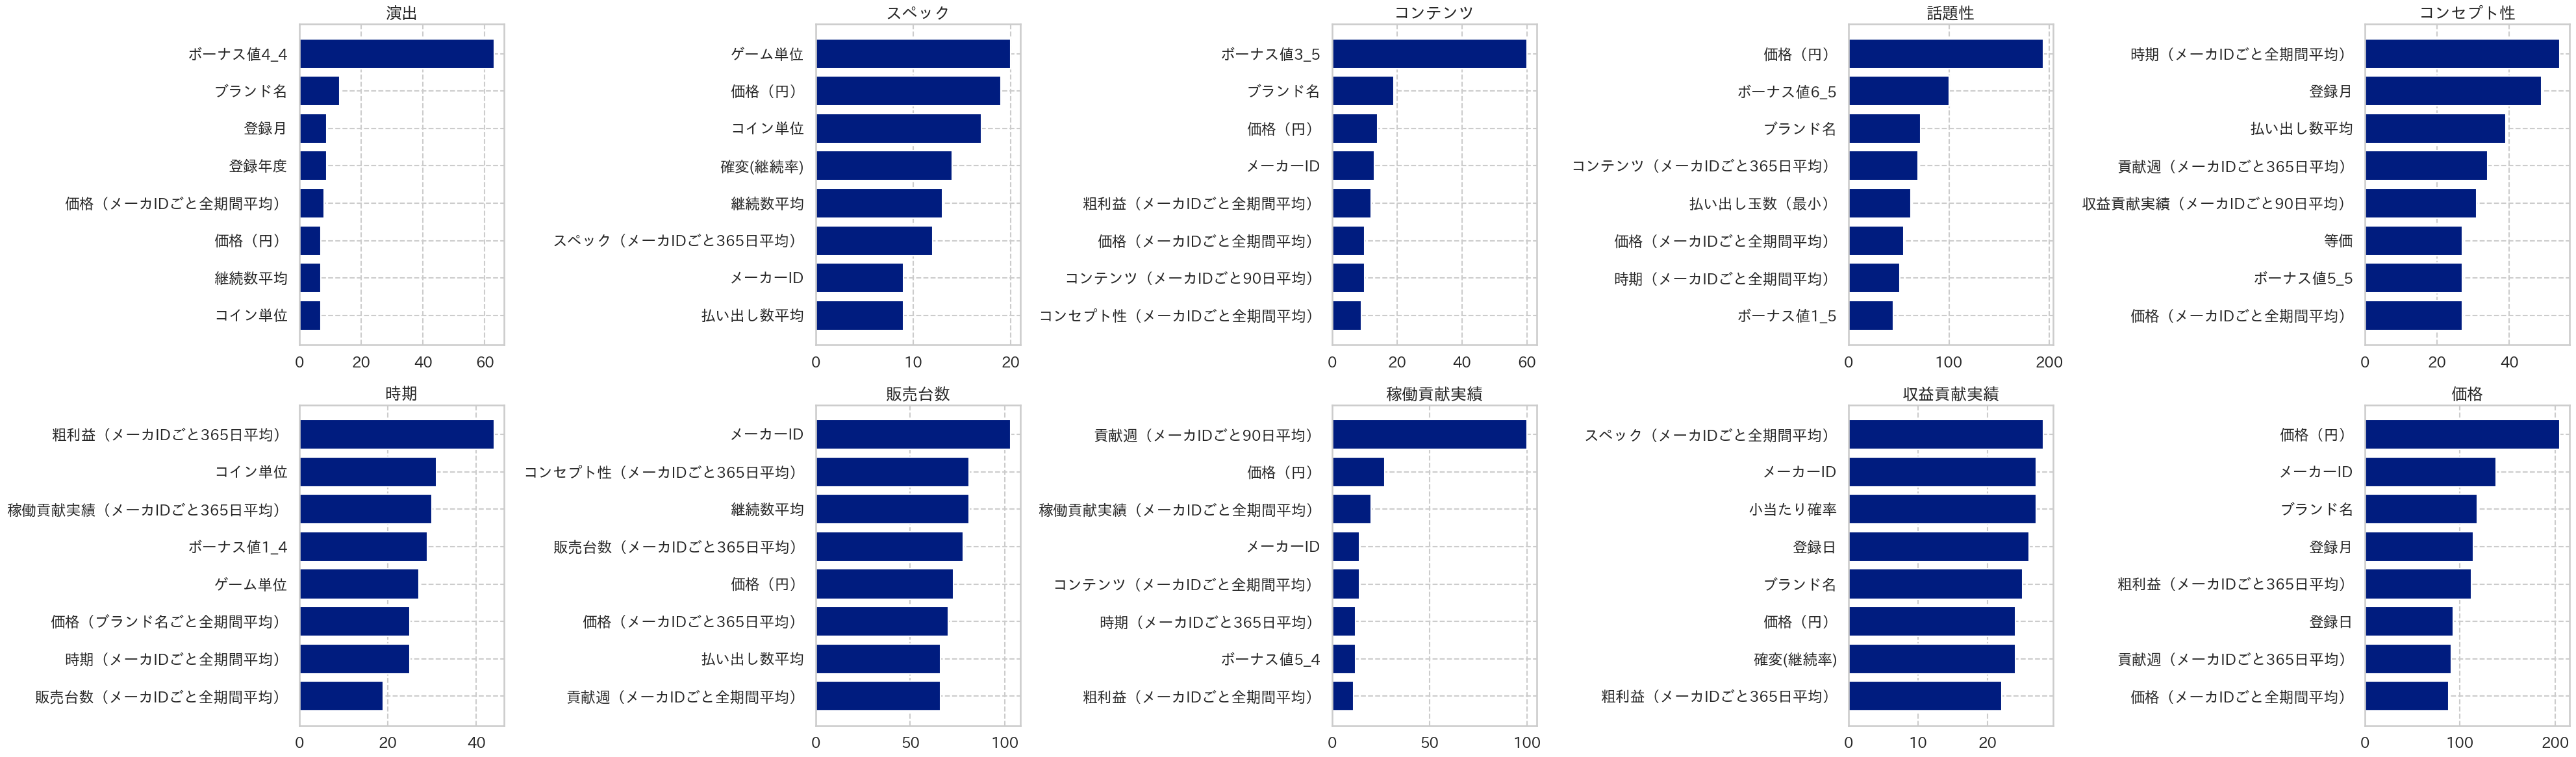

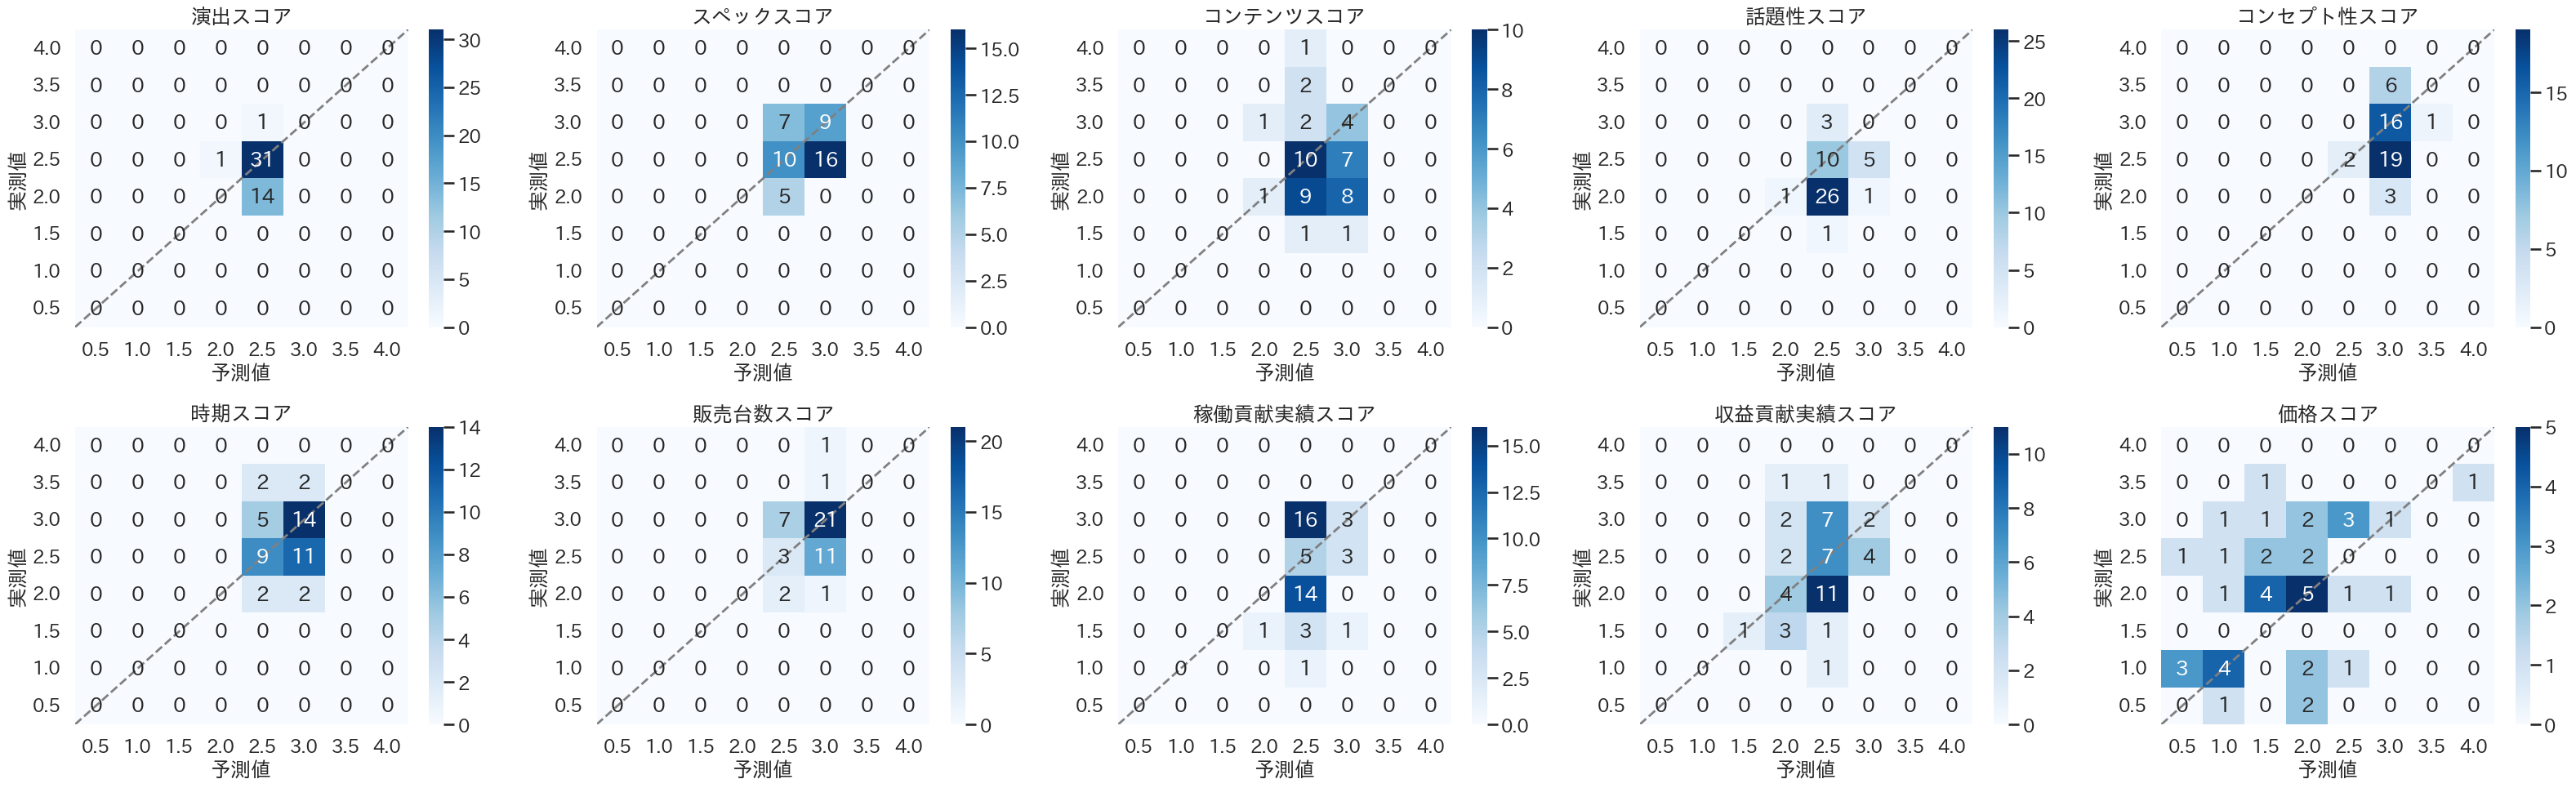

In [22]:
###############(評価値に対して)パラメータを読み込んで学習とテスト　###############
from src.modeling import modeling
from src.evaluation import evaluation

m = modeling(features, targets_eval)
# 読み込んで学習データに学習、テストデータに推論
models_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_lightgbm_20200117to20231017.json',
                              model_kind='lightgbm_regressor')
df_output_gbm = m.predict_all(models_gbm, df_test)

folder = 'output_train/train20200117to20231017_test20231018to20240415'

### 評価値 ###
suffix = 'gbm_tuned'
eval = evaluation(folder, suffix)
eval.generate(df_output_gbm, models_gbm, targets_eval, features)

### 全期間で学習して保存 ####
models_gbm = m.load_and_train_all(df, # 全期間のデータ
                              param_path='hyperparameters/best_parameters_lightgbm_20200117to20231017.json',
                              model_kind='lightgbm_regressor')

import pickle
with open(folder + '/model_'+suffix+'.pickle', 'wb') as handle:
    pickle.dump(models_gbm, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 推論20240415~20240531

In [50]:
############### 最新のデータを読み込む ###############
data_model = data_preprocessing_operator(start_date="2020/01/01 00:00:00",
                                        end_date="2024/05/31 23:59:59",
                                        openai_api_key=config['openai']['api_key'],
                                        use_existing_brand=True,
                                        brand_output_path='brand_lists/brand_list_20200101_20240415.csv',
                                        fit_categorical_values=False, # カテゴリは前回保存したpickleファイルを使用
                                        start_date_of_prediction='2024/04/16 00:00:00') # 推論開始日の指定

existing_brand_path = 'brand_lists/brand_list_20200101_20240616.csv'

df = data_model.process( 
                df_frame,
                df_katashiki,
                df_pachinko,
                df_slot,
                df_katashiki_frame_relation,
                df_model_evaluation,
                df_pachinko_type,
                df_pachinko_type_detail, existing_brand_path)

# ここで予測対象の日付以上にする
df = df[df['Regist_Date'] >= '2024/04/16 00:00:00']

In [51]:
df[df['Name'].isin(['eフィーバー機動戦士ガンダムユニコーン2 R',
                    'Pフィーバー機動戦士ガンダムユニコーン2 S',
                   'e北斗の拳10 GHEG'])][['KatashikiId', 'Name', 'Regist_Date']]

,KatashikiId,Name,Regist_Date
286,P2024043013314701,e北斗の拳10 GHEG,2024-05-13 12:38:09
335,P2024051018464901,Pフィーバー機動戦士ガンダムユニコーン2 S,2024-05-20 16:01:29
336,P2024051516140101,eフィーバー機動戦士ガンダムユニコーン2 R,2024-05-20 16:02:21


In [52]:
len(df)

21

In [53]:
############### モデルの読み込み ###############
# run_jobs.ipynbで保存したモデル
folder = 'output_train/train20200117to20231017_test20231018to20240415'
suffix = 'gbm_tuned'
with open(folder + '/model_'+suffix+'.pickle', 'rb') as handle:
    models = pickle.load(handle)

In [54]:
m = modeling(features, targets_eval)

df_output = m.predict_all(models, df)

In [55]:
df_output

,Kind,Performance,Spec,Content,News,Concept,Period,SaleUnit_eval,Running,Returns,...,Performance_pred,Spec_pred,Content_pred,News_pred,Concept_pred,Period_pred,SaleUnit_eval_pred,Running_pred,Returns_pred,Price_eval_pred
13,1,2.25,2.50,2.25,2.50,2.50,2.75,2.50,2.50,2.25,...,2.40,2.35,2.50,2.50,2.70,2.70,2.75,2.35,2.50,1.10
68,1,2.25,2.75,2.25,2.00,2.75,2.75,2.75,2.00,2.00,...,2.35,2.55,2.45,2.40,2.75,2.65,2.65,1.95,1.95,0.95
73,0,2.50,2.50,2.50,2.25,2.50,2.50,3.00,2.70,2.70,...,2.40,2.50,2.50,2.20,2.50,2.50,2.60,2.50,2.65,1.00
123,1,2.00,2.40,2.00,2.00,2.25,2.75,2.25,2.75,2.75,...,2.45,2.65,2.30,2.25,2.75,2.50,2.60,2.55,2.80,0.95
128,1,2.60,2.50,2.00,2.50,2.25,2.75,3.00,3.00,3.00,...,2.30,2.60,2.55,2.25,2.75,2.55,2.80,2.25,2.05,1.25
156,1,2.50,2.50,2.50,2.25,2.75,3.00,3.00,1.50,1.50,...,2.30,2.30,2.55,2.35,3.00,2.60,2.60,2.30,2.80,0.35
173,1,1.75,2.25,1.75,2.00,2.00,2.50,3.00,2.00,2.00,...,2.20,2.65,2.25,2.25,2.95,2.70,2.45,2.25,2.40,0.35
198,1,1.75,2.50,1.00,2.00,3.25,2.00,3.00,1.75,1.50,...,1.95,2.30,2.40,1.80,2.85,2.40,2.75,2.05,1.55,3.55
200,0,2.20,2.50,2.75,3.00,2.50,2.25,2.75,2.00,2.00,...,2.45,2.60,2.40,2.15,2.60,2.50,2.65,2.50,2.45,1.75
233,1,2.00,2.35,4.50,2.25,3.50,2.25,3.00,4.75,4.75,...,2.10,2.15,2.40,2.30,3.00,2.50,2.80,2.00,1.95,1.85


In [56]:
def get_actual_pred_abs_diff(df):
    for target in targets_eval:
        df[target + '_diff'] = df[target] - df[target + '_pred']
        df[target + '_diff'] = df[target + '_diff'].abs()
    return df

from data_columns.en_jp_dictionary import *

features_en_to_jp = {}
features_en_to_jp.update(features_jp)
features_en_to_jp.update(targets_jp)
features_en_to_jp.update(targets_pred_jp)

for target in targets_eval:
    features_en_to_jp.update({target+'_diff': features_en_to_jp[target] + '_絶対差分'})

In [57]:
df_output = get_actual_pred_abs_diff(df_output)

In [58]:
# 並び替え
list_cols = ['Kind']
for target in targets_eval:
    list_cols.extend([target, target+'_pred', target+'_diff'])

df_output = df_output[list_cols]

In [59]:

features_2 = [x for x in features if x not in ['KatashikiId', 'Price', 'Name', 'brand_name']]
df_eval = pd.concat([df[['KatashikiId', 'Price', 'Name', 'brand_name']], df_output, df[features_2]], axis=1) 

df_eval = df_eval.rename(columns=features_en_to_jp)

In [60]:
df_eval = df_eval.rename(columns={'KatashikiId':'型式ID', 'Name': '型式名', 'brand_name':'ブランド名（型式名から抽出）'})

In [61]:
df_eval.to_csv('output_analysis/実績値と予測値の比較_20240416_20240531.csv', index=False)